<a href="https://colab.research.google.com/github/nadyaloseva/ML_itmo/blob/main/%D0%9C%D0%B0%D1%88_%D0%BE%D0%B1%D1%83%D1%87_%D0%BB%D0%B0%D0%B12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Реализуемый класс должен

- Поддерживать создание любого числа слоев с любым числом нейронов.
- Тип инициализации весов не регламентируется.
- Обеспечивать выбор следующих функции активации в рамках каждого слоя: ReLU, sigmoid, linear.
- Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
- В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
- Поддерживать использование l1, l2 и l1l2 регуляризаций.


### Реализация класса

In [69]:
import numpy as np

class MyMLP:
    def __init__(self, layer_sizes, init_method="xavier", activations=None,
                 learning_rate=0.01, num_iterations=1000, regularization=None,
                 lambda_1=0.01, lambda_2=0.01, batch_size=32, loss_type="mse"):
        self._layer_sizes = layer_sizes # размер слоёв
        self._weights = [] # метод инициализации весов
        self._bias = []
        self.learning_rate = learning_rate # скорость обучение
        self.num_iterations = num_iterations
        self.regularization = regularization
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.loss_type = loss_type  # тип функции потерь

        if activations is None:
            self._activations = ['relu'] * (len(layer_sizes) - 2) + ['linear']
        else:
            if len(activations) != len(layer_sizes) - 1:
                raise ValueError("Количество функций активации должно быть на 1 меньше количества слоев")
            self._activations = activations

        for i in range(len(layer_sizes) - 1):
            n_in, n_out = layer_sizes[i], layer_sizes[i + 1]
            if init_method == "random":
                W = np.random.randn(n_in, n_out)
            elif init_method == "xavier":
                W = np.random.randn(n_in, n_out) * np.sqrt(1 / n_in)
            elif init_method == "he":
                W = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)
            elif init_method == "zeros":
                W = np.zeros((n_in, n_out))
            elif init_method == "ones":
                W = np.ones((n_in, n_out))
            else:
                raise ValueError("Неизвестный метод инициализации весов")
            self._weights.append(W)
            self._bias.append(np.zeros(n_out))

    def activate(self, x, func_name):
        if func_name == 'relu': return np.maximum(0, x)
        if func_name == 'sigmoid':
          x = np.clip(x, -100, 100)
          return 1 / (1 + np.exp(-x))
        if func_name == 'linear': return x
        if func_name == 'softmax':
          x = x - np.max(x, axis=1, keepdims=True)
          exps = np.exp(x)
          return exps / np.sum(exps, axis=1, keepdims=True)

        if np.any(np.isnan(x)):
          print("NaN in x before activation", func_name)
        raise ValueError("Неизвестная функция активации")

    def activate_derivative(self, x, func_name):
        if func_name == 'relu': return (x > 0).astype(float)
        if func_name == 'sigmoid':
            s = 1 / (1 + np.exp(-x))
            return s * (1 - s)
        if func_name == 'linear': return np.ones_like(x)
        if func_name == 'softmax':
            s = self.activate(x, 'softmax')
            return s * (1 - s)
        raise ValueError("Неизвестная функция активации")

    # вычисляем значение функции потерь
    def loss(self, y_pred, y_true):
        if self.loss_type == 'mse':  # Mean Squared Error
            return np.mean((y_pred - y_true) ** 2)
        elif self.loss_type == 'binary_crossentropy':  # Binary Crossentropy
            return -np.mean(y_true * np.log(y_pred + 1e-9) + (1 - y_true) * np.log(1 - y_pred + 1e-9))
        elif self.loss_type == 'categorical_crossentropy':  # Categorical Crossentropy
            return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))
        else:
            raise ValueError(f"Неизвестная функция потерь: {self.loss_type}")

    # вычисляем градиент функции потери по предсказанию
    def loss_derivative(self, y_pred, y_true):
        if self.loss_type == 'mse':
            return 2 * (y_pred - y_true) / y_true.shape[0]
        elif self.loss_type == 'binary_crossentropy':
            return (y_pred - y_true) / (y_pred * (1 - y_pred))
        elif self.loss_type == 'categorical_crossentropy':
            return (y_pred - y_true) / y_true.shape[0]
        else:
            raise ValueError(f"Неизвестная функция потерь: {self.loss_type}")

    # прямой проход (делаем предсказание)
    def forward(self, X):
        self._z = [] # линейная комбинация до активации для каждого слоя
        self._a = [X] # выходы активаций каждого слоя
        for i in range(len(self._weights)):
            z = self._a[-1] @ self._weights[i] + self._bias[i]
            a = self.activate(z, self._activations[i])
            self._z.append(z)
            self._a.append(a)
        if np.isnan(self._a[-1]).any():
            print("NaN in output!")
            print(self._a[-1])
        return self._a[-1]

    # обратный проход (для вычисления градиента функции потери по весам)
    def backward(self, y):
        grads_W = [None] * len(self._weights)
        grads_b = [None] * len(self._bias)

        if self.loss_type == 'categorical_crossentropy' and self._activations[-1] == 'softmax':
          delta = self._a[-1] - y
        else:
          delta = self.loss_derivative(self._a[-1], y) * self.activate_derivative(self._z[-1], self._activations[-1]) #вычисление ошиька на последнем слое
        grads_W[-1] = self._a[-2].T @ delta # градиент весов последнего слоя
        grads_b[-1] = np.sum(delta, axis=0) # градиент смещенний последнего слоя

        for i in reversed(range(len(self._weights) - 1)):
            delta = (delta @ self._weights[i + 1].T) * self.activate_derivative(self._z[i], self._activations[i])
            grads_W[i] = self._a[i].T @ delta
            grads_b[i] = np.sum(delta, axis=0)

        return grads_W, grads_b

    def update_weights(self, grads_W, grads_b):
        for i in range(len(self._weights)):
            reg_term = 0
            if self.regularization == 'l2':
                reg_term = self.lambda_2 * self._weights[i]  / self.batch_size
            elif self.regularization == 'l1':
                reg_term = self.lambda_1 * np.sign(self._weights[i])  / self.batch_size
            elif self.regularization == 'l1l2':
                reg_term = self.lambda_1 * np.sign(self._weights[i]) + self.lambda_2 * self._weights[i]

            self._weights[i] -= self.learning_rate * (grads_W[i] + reg_term)  # без деления на batch_size
            self._bias[i] -= self.learning_rate * grads_b[i]

    def fit(self, X, y):
      if len(y.shape) == 1: #если y - одномерный массив, то превращаем его в двумерный, чтобы работать в матричном виде
          y = np.asarray(y).reshape(-1, 1)

      accuracy = 0  # Инициализируем переменную accuracy

      for epoch in range(self.num_iterations): # обучение по эпохам
          indices = np.random.permutation(X.shape[0]) # данные случайным образомо перемешиваются для каждой эпохи
          for i in range(0, X.shape[0], self.batch_size): # рабиваем на батчи и смотрим по ним
              batch_idx = indices[i:i + self.batch_size]
              X_batch, y_batch = X[batch_idx], y[batch_idx]
              output = self.forward(X_batch) # вычисляем линейные комбинации и активации на каждом слое, в результате получаем предсказание
              grads_W, grads_b = self.backward(y_batch) # вычисляем градиент для изменения весов и смещения
              self.update_weights(grads_W, grads_b) # обновляем веса

          # вычисление точности на каждой эпохе
          if epoch % 100 == 0:
              accuracy = self.score(X, y)
              #print(f"Epoch {epoch}/{self.num_iterations}, Accuracy: {accuracy}")

      return accuracy

    def predict(self, X):
        return self.forward(X)

    def predict_proba(self, X):
        return self.forward(X)

    def score(self, X, y):
        y = np.asarray(y)
        y_pred = self.predict(X)
        if self.loss_type == 'mse':
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            return 1 - ss_res / ss_tot

        elif self.loss_type == 'binary_crossentropy':
            y_pred_binary = (y_pred >= 0.5).astype(int)
            return np.mean(y_pred_binary == y)
        elif self.loss_type == 'categorical_crossentropy':
            correct_preds = np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)
            return np.mean(correct_preds)
        else:
            raise ValueError(f"Неизвестная метрика для функции потерь {self.loss_type}")


In [1]:
import numpy as np

class MyMLP:
    def __init__(self, layer_sizes, init_method="xavier", activations=None,
                 learning_rate=0.01, num_iterations=1000, regularization=None,
                 lambda_1=0.01, lambda_2=0.01, batch_size=32, loss_type="mse"):
        self._layer_sizes = layer_sizes
        self._weights = []
        self._bias = []
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.regularization = regularization
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.loss_type = loss_type

        if activations is None:
            self._activations = ['relu'] * (len(layer_sizes) - 2) + ['linear']
        else:
            if len(activations) != len(layer_sizes) - 1:
                raise ValueError("Количество функций активации должно быть на 1 меньше количества слоев")
            self._activations = activations

        for i in range(len(layer_sizes) - 1):
            n_in, n_out = layer_sizes[i], layer_sizes[i + 1]
            if init_method == "random":
                W = np.random.randn(n_in, n_out) * 0.01
            elif init_method == "xavier":
                W = np.random.randn(n_in, n_out) * np.sqrt(2 / (n_in + n_out))
            elif init_method == "he":
                W = np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)
            elif init_method == "zeros":
                W = np.zeros((n_in, n_out))
            elif init_method == "ones":
                W = np.ones((n_in, n_out))
            else:
                raise ValueError("Неизвестный метод инициализации весов")
            self._weights.append(W)
            self._bias.append(np.zeros(n_out))

    def activate(self, x, func_name):
        x = np.clip(x, -500, 500)  # Prevent overflow
        if func_name == 'relu':
            return np.maximum(0, x)
        if func_name == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        if func_name == 'linear':
            return x
        if func_name == 'softmax':
            x = x - np.max(x, axis=1, keepdims=True)
            exps = np.exp(np.clip(x, -100, 100))
            return exps / np.sum(exps, axis=1, keepdims=True)
        raise ValueError("Неизвестная функция активации")

    def activate_derivative(self, x, func_name):
        x = np.clip(x, -500, 500)  # обрезаем значения для избежания переполнения
        if func_name == 'relu':
            return (x > 0).astype(float)
        if func_name == 'sigmoid':
            s = 1 / (1 + np.exp(-x))
            return s * (1 - s)
        if func_name == 'linear':
            return np.ones_like(x)
        if func_name == 'softmax':
            s = self.activate(x, 'softmax')
            return s * (1 - s)
        raise ValueError("Неизвестная функция активации")

    # вычисляем значение функции потерь
    def loss(self, y_pred, y_true):
        eps = 1e-9
        y_pred = np.clip(y_pred, eps, 1 - eps)
        if self.loss_type == 'mse':
            return np.mean((y_pred - y_true) ** 2)
        elif self.loss_type == 'binary_crossentropy':
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        elif self.loss_type == 'categorical_crossentropy':
            return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        else:
            raise ValueError(f"Неизвестная функция потерь: {self.loss_type}")

    def loss_derivative(self, y_pred, y_true):
        eps = 1e-9
        y_pred = np.clip(y_pred, eps, 1 - eps)
        if self.loss_type == 'mse':
            return 2 * (y_pred - y_true) / y_true.shape[0]
        elif self.loss_type == 'binary_crossentropy':
            return (y_pred - y_true) / (y_pred * (1 - y_pred) + eps)
        elif self.loss_type == 'categorical_crossentropy':
            return (y_pred - y_true) / y_true.shape[0]
        else:
            raise ValueError(f"Неизвестная функция потерь: {self.loss_type}")

    # прямой проход (делаем предсказание)
    def forward(self, X):
        self._z = []
        self._a = [X]
        for i in range(len(self._weights)):
            z = self._a[-1] @ self._weights[i] + self._bias[i]
            z = np.clip(z, -500, 500)  # Clip to avoid overflow
            a = self.activate(z, self._activations[i])
            self._z.append(z)
            self._a.append(a)
        if np.isnan(self._a[-1]).any() or np.isinf(self._a[-1]).any():
            print("NaN or Inf in output! Last activation:", self._activations[-1])
        return self._a[-1]

    # обратный проход (для вычисления градиента функции потери по весам)
    def backward(self, y):
        grads_W = [None] * len(self._weights)
        grads_b = [None] * len(self._bias)

        if self.loss_type == 'categorical_crossentropy' and self._activations[-1] == 'softmax':
            delta = self._a[-1] - y
        else:
            delta = self.loss_derivative(self._a[-1], y) * self.activate_derivative(self._z[-1], self._activations[-1])

        grads_W[-1] = self._a[-2].T @ delta
        grads_b[-1] = np.sum(delta, axis=0)

        for i in reversed(range(len(self._weights) - 1)):
            delta = (delta @ self._weights[i + 1].T) * self.activate_derivative(self._z[i], self._activations[i])
            grads_W[i] = self._a[i].T @ delta # градиент весов последнего слоя
            grads_b[i] = np.sum(delta, axis=0) # градиент смещенний последнего слоя

        # Check for NaN/Inf in grads
        for i, g in enumerate(grads_W):
            if np.isnan(g).any() or np.isinf(g).any():
                print(f"NaN/Inf in grads_W[{i}]")
        return grads_W, grads_b

    def update_weights(self, grads_W, grads_b):
        for i in range(len(self._weights)):
            reg_term = 0
            if self.regularization == 'l2':
                reg_term = self.lambda_2 * self._weights[i] / self.batch_size
            elif self.regularization == 'l1':
                reg_term = self.lambda_1 * np.sign(self._weights[i]) / self.batch_size
            elif self.regularization == 'l1l2':
                reg_term = self.lambda_1 * np.sign(self._weights[i]) + self.lambda_2 * self._weights[i]

            update_W = self.learning_rate * (grads_W[i] + reg_term)
            update_b = self.learning_rate * grads_b[i]

            if np.any(np.isnan(update_W)) or np.any(np.isinf(update_W)):
                print(f"NaN/Inf in weight update at layer {i}")

            self._weights[i] -= update_W
            self._bias[i] -= update_b

    def fit(self, X, y):
        if len(y.shape) == 1:#если y - одномерный массив, то превращаем его в двумерный, чтобы работать в матричном виде
            y = y.reshape(-1, 1)
        for epoch in range(self.num_iterations): # обучение по эпохам
            indices = np.random.permutation(X.shape[0]) # данные случайным образомо перемешиваются для каждой эпохи
            for i in range(0, X.shape[0], self.batch_size):  # рабиваем на батчи и смотрим по ним
                batch_idx = indices[i:i + self.batch_size]
                X_batch, y_batch = X[batch_idx], y[batch_idx]
                output = self.forward(X_batch) # вычисляем линейные комбинации и активации на каждом слое, в результате получаем предсказание
                grads_W, grads_b = self.backward(y_batch) # вычисляем градиент для изменения весов и смещения
                self.update_weights(grads_W, grads_b)  # обновляем веса
            # вычисление точности на каждой эпохе
            if epoch % 100 == 0:
                acc = self.score(X, y)
                #print(f"Epoch {epoch}, score: {acc:.4f}")
        return self.score(X, y)

    def predict(self, X):
        return self.forward(X)

    def predict_proba(self, X):
        return self.forward(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        if self.loss_type == 'mse':
            ss_res = np.sum((y - y_pred) ** 2)
            ss_tot = np.sum((y - np.mean(y)) ** 2)
            return 1 - ss_res / ss_tot
        elif self.loss_type == 'binary_crossentropy':
            return np.mean((y_pred >= 0.5).astype(int) == y)
        elif self.loss_type == 'categorical_crossentropy':
            return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
        else:
            raise ValueError(f"Неизвестная метрика для функции потерь {self.loss_type}")



Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций) и сравнить результаты работы (оценка качества модели + время обучения и инференса) реализованного класса `MyMLP` со следующими моделям (в одинаковых конфигурациях):

*   MLPClassifier/MLPRegressor из sklearn
*   TensorFlow
*   Keras
*   PyTorch

Результат представить в виде .ipynb блокнота, содержащего весь необходимый код и визуализации сравнения реализаций для рассмотренных конфигураций.


### Классификация

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy
from keras.layers import Activation, Dense, Input
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time

In [3]:
df = pd.read_csv(r"/content/character-predictions.csv")

In [4]:
df[['isPopular', 'age', 'isNoble', 'male', 'book1', 'book2', 'book3', 'book4', 'book5']].iloc[5]

,5
isPopular,1.0
age,NaN
isNoble,0.0
male,1.0
book1,0.0
book2,0.0
book3,0.0
book4,0.0
book5,0.0


In [5]:
df[['isPopular', 'age', 'isNoble', 'male', 'book1', 'book2', 'book3', 'book4', 'book5']].describe()

,isPopular,age,isNoble,male,book1,book2,book3,book4,book5
count,1946.000000,433.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000,1946.000000
mean,0.059096,-1293.563510,0.460946,0.619219,0.198356,0.374615,0.480473,0.591984,0.395170
std,0.235864,19564.340993,0.498601,0.485704,0.398864,0.484148,0.499747,0.491593,0.489013
min,0.000000,-298001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,50.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


isAlive - наша целевая переменная(признак смерти)

для классификации оставимь простые и понятные признаки типо: book1, book2, book3 и т.д.

In [6]:
X = df[['isPopular', 'isNoble', 'male', 'book1', 'book2', 'book3', 'book4', 'book5']]
y = df['isAlive'].astype(int)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# обучение
my_mlp = MyMLP(
    layer_sizes=[X_train.shape[1], 20, 1],
    activations=['relu', 'sigmoid'],
    loss_type='binary_crossentropy',
    learning_rate=0.01,
    num_iterations=1000,
    batch_size=32
)
my_mlp.fit(X_train, y_train)
print("MyMLP Accuracy:", my_mlp.score(X_test, y_test))

MyMLP Accuracy: 0.7846153846153846


In [11]:
sk_mlp = MLPClassifier(
    hidden_layer_sizes=(20,),
    activation='relu',
    solver='sgd',
    learning_rate_init=0.01,
    max_iter=1000,
    batch_size=32,
    random_state=42
)
sk_mlp.fit(X_train, y_train.ravel())  # y должен быть одномерным


MLPClassifier(batch_size=32, hidden_layer_sizes=(20,), learning_rate_init=0.01,
              max_iter=1000, random_state=42, solver='sgd')

In [12]:
# модель моя
my_preds = (my_mlp.predict(X_test) >= 0.5).astype(int)
my_acc = accuracy_score(y_test, my_preds)

# sklearn модель
sk_preds = sk_mlp.predict(X_test)
sk_acc = accuracy_score(y_test, sk_preds)

print(f"MyMLP Accuracy:      {my_acc:.4f}")
print(f"Sklearn MLP Accuracy: {sk_acc:.4f}")


MyMLP Accuracy:      0.7846
Sklearn MLP Accuracy: 0.7692


In [13]:
configurations = [
    {'hidden_layer_sizes': (200, 150, 100, 50), 'activation': 'relu', 'learning_rate_init': 0.001, 'num_hidden_layer_sizes':4},
    {'hidden_layer_sizes': (200, 150, 100, 50), 'activation': 'relu', 'learning_rate_init': 0.003, 'num_hidden_layer_sizes':4},
    {'hidden_layer_sizes': (256, 128, 64, 32, 16), 'activation': 'relu', 'learning_rate_init': 0.0005, 'num_hidden_layer_sizes':5},
    {'hidden_layer_sizes': (256, 128, 64, 32, 16), 'activation': 'relu', 'learning_rate_init': 0.0003, 'num_hidden_layer_sizes':5},
    {'hidden_layer_sizes': (300, 200, 150, 100, 50, 25, 10), 'activation': 'relu', 'learning_rate_init': 0.0001, 'num_hidden_layer_sizes':7},
    {'hidden_layer_sizes': (300, 200, 150, 100, 50, 25, 10), 'activation': 'relu', 'learning_rate_init': 0.0003, 'num_hidden_layer_sizes':7},
    {'hidden_layer_sizes': (1024, 512, 256, 128, 64, 32, 16, 8), 'activation': 'relu', 'learning_rate_init': 0.0001, 'num_hidden_layer_sizes':8}
]

In [14]:
# Словарь для хранения результатов
results = {'model': [], 'config': [], 'accuracy': [], 'training_time': [], 'num_hidden_layer_sizes':[]}

## Классификация

### keras

In [15]:
# keras для классификации и регресси

def create_keras_model(hidden_layer_sizes, activation, input_dim, learning_rate=0.001, task='classification'):
    activation_map = {
        'logistic': 'sigmoid',
        'identity': 'linear'
    }
    keras_activation = activation_map.get(activation, activation)

    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    for units in hidden_layer_sizes:
        model.add(Dense(units, activation=keras_activation))

    if task == 'classification':
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    elif task == 'regression':
        model.add(Dense(1))  # Без активации
        loss = 'mean_squared_error'
        metrics = ['mae']  # Или ['mse']

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def train_keras_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    training_time = time.time() - start_time
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    return accuracy, training_time

In [16]:
# классификация
for config in configurations:
    input_dim = X_train.shape[1]
    keras_model = create_keras_model(
        hidden_layer_sizes=config['hidden_layer_sizes'],
        activation=config['activation'],
        input_dim=input_dim,
        learning_rate=config['learning_rate_init']
    )

    accuracy, training_time = train_keras_model(keras_model, X_train, y_train, X_test, y_test)
    results['model'].append('Keras')
    results['config'].append(config)
    results['accuracy'].append(accuracy)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])

### MLPClassifier/MLPRegressor из sklearn

In [17]:
def train_mlp_model(model, X_train, y_train, X_test, y_test, config):
    # Получаем значение активации из конфигурации
    activation = config['activation']

    # Заменяем 'sigmoid' на 'logistic' только для классификации
    if isinstance(model, MLPClassifier) and activation == 'sigmoid':
        activation = 'logistic'

    if isinstance(model, MLPRegressor) and activation == 'sigmoid':
        activation = 'logistic'

    # Установка параметров модели
    model.set_params(
        hidden_layer_sizes=config['hidden_layer_sizes'],
        activation=activation,
        learning_rate_init=config['learning_rate_init']
    )

    # Обучение модели
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Оценка модели
    if isinstance(model, MLPClassifier):
        score = model.score(X_test, y_test)  # Для классификации
    else:
        score = model.score(X_test, y_test)  # Для регрессии (например, R²)

    return score, training_time

In [18]:
for config in configurations:
    model = MLPClassifier(
        hidden_layer_sizes=config['hidden_layer_sizes'],
        activation=config['activation'],
        learning_rate_init=config['learning_rate_init'],
        max_iter=500
    )
    # Обучаем модель
    score, training_time = train_mlp_model(model, X_train, y_train, X_test, y_test, config)

    # Добавляем результаты в словарь
    results['model'].append('MLPClassifier')
    results['config'].append(config)  # Сохраняем конфигурацию как словарь
    results['accuracy'].append(score)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed w

### MLP_PyTorch

In [19]:
def create_mlp_functional(layer_sizes, activation):
    layers = []
    for i in range(len(layer_sizes) - 1):
        layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
        if i < len(layer_sizes) - 2:  # активация — только до последнего слоя
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            else:
                raise ValueError(f"Unsupported activation: {activation}")
    return nn.Sequential(*layers)


In [20]:
loss_fn = nn.BCEWithLogitsLoss()  # для бинарной классификации (без Sigmoid на выходе)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

for config in configurations:
    # Слои: входной размер + скрытые + выходной
    layer_sizes = [X_train.shape[1]] + list(config['hidden_layer_sizes']) + [1]
    model = create_mlp_functional(layer_sizes, config['activation'])

    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate_init'])

    start_time = time.time()
    model.train()
    for epoch in range(20):  # можно больше/меньше
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    training_time = time.time() - start_time

    # Оценка
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        preds = torch.sigmoid(outputs) > 0.5
        accuracy = (preds == y_test_tensor).float().mean().item()

    results['model'].append('MLP_PyTorch')
    results['config'].append(config)
    results['accuracy'].append(accuracy)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])

### Мой класс

In [21]:
def train_model(model, X_train, y_train, X_test, y_test, task='regression'):
    import time
    start_time = time.time()

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание
    y_pred = model.predict(X_test)

    # Метрика в зависимости от задачи
    if task == 'regression':
        score = model.score(X_test, y_test)
    elif task == 'classification':
        # Классификационные метрики требуют округления (если нужно)
        y_pred_class = (y_pred > 0.5).astype(int) if y_pred.ndim > 1 else y_pred
        score = accuracy_score(y_test, y_pred_class)
    else:
        raise ValueError("Unsupported task type. Use 'regression' or 'classification'.")

    training_time = time.time() - start_time
    return score, training_time


In [22]:
for config in configurations:
    activations = ['relu'] * len(config['hidden_layer_sizes']) + ['sigmoid']

    my_mlp = MyMLP(
        layer_sizes=[X_train.shape[1]] + list(config['hidden_layer_sizes']) + [1],
        activations=activations,
        loss_type='binary_crossentropy',
        learning_rate=config['learning_rate_init'],
        num_iterations=1000,
        batch_size=32
    )

    accuracy, training_time = train_model(my_mlp, X_train, y_train, X_test, y_test,  task='classification')
    results['model'].append('MyMLP')
    results['config'].append(config)
    results['accuracy'].append(accuracy)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])

### Итоговый датафрейм

In [23]:
min_len = min(len(results[k]) for k in results)
for k in results:
    results[k] = results[k][:min_len]

itog = pd.DataFrame(results)

In [24]:
config_df = pd.json_normalize(itog['config'])

itog = pd.concat([itog[['model']], config_df, itog[['accuracy', 'training_time']]], axis=1)

In [34]:
display(itog)

,model,hidden_layer_sizes,activation,learning_rate_init,num_hidden_layer_sizes,accuracy,training_time
0,Keras,"(200, 150, 100, 50)",relu,0.0010,4,0.774359,4.492824
1,Keras,"(200, 150, 100, 50)",relu,0.0030,4,0.784615,4.052352
2,Keras,"(256, 128, 64, 32, 16)",relu,0.0005,5,0.782051,5.297372
3,Keras,"(256, 128, 64, 32, 16)",relu,0.0003,5,0.779487,4.405364
4,Keras,"(300, 200, 150, 100, 50, 25, 10)",relu,0.0001,7,0.771795,6.828322
5,Keras,"(300, 200, 150, 100, 50, 25, 10)",relu,0.0003,7,0.769231,5.631519
6,Keras,"(1024, 512, 256, 128, 64, 32, 16, 8)",relu,0.0001,8,0.779487,13.188277
7,Keras,"(200, 150, 100, 50)",relu,0.0010,4,0.787179,4.872754
8,Keras,"(200, 150, 100, 50)",relu,0.0030,4,0.774359,5.001432
9,Keras,"(256, 128, 64, 32, 16)",relu,0.0005,5,0.776923,4.785512


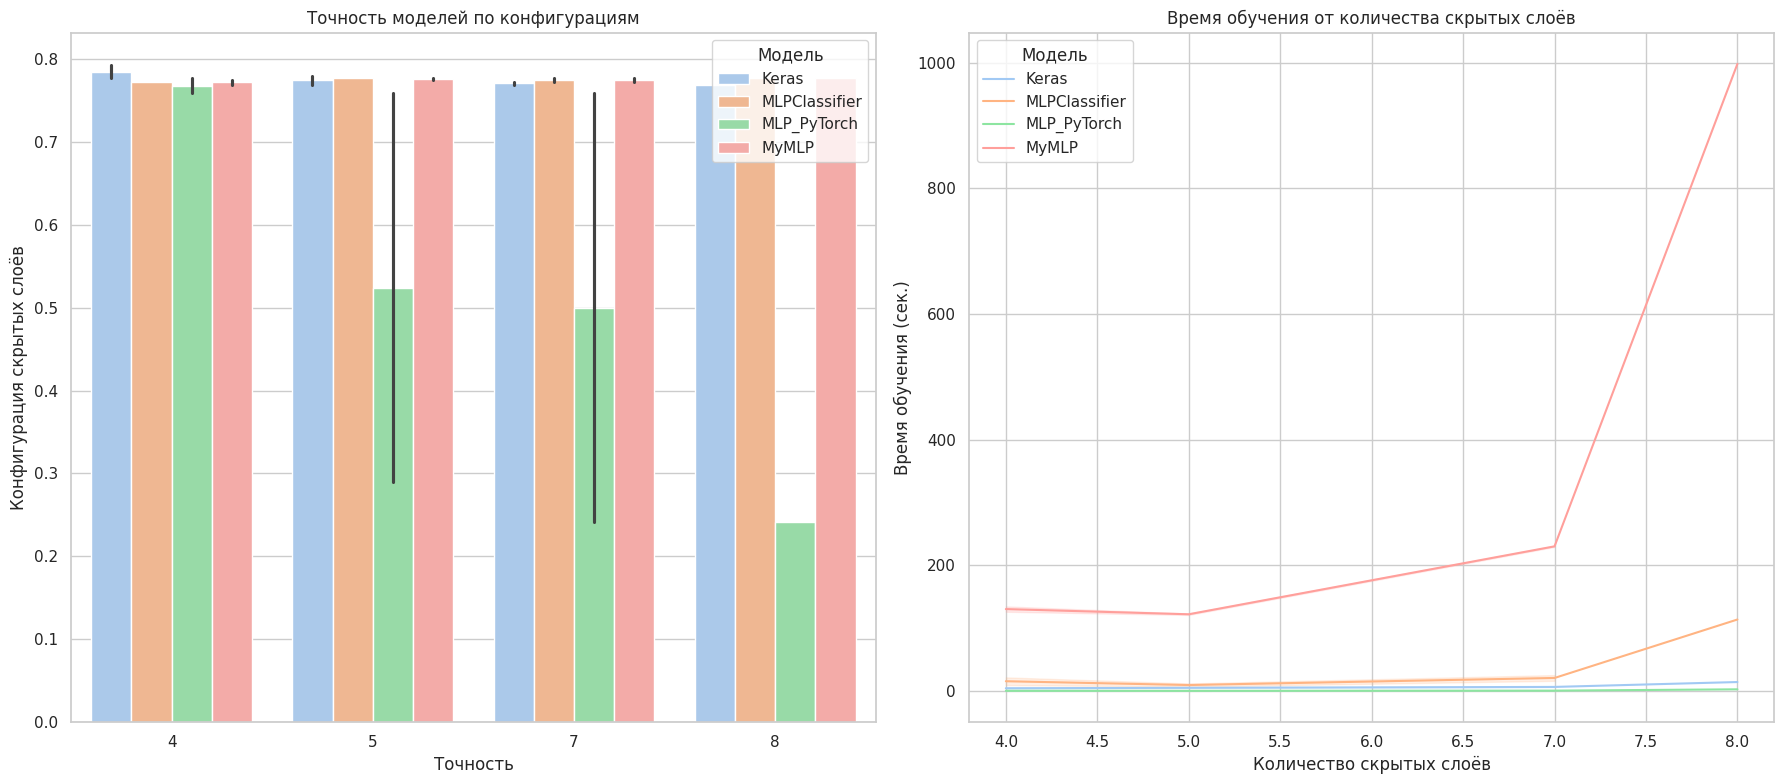

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

itog['hidden_layer_sizes_str'] = itog['hidden_layer_sizes'].astype(str)

# Устанавливаем стиль и палитру
sns.set(style="whitegrid", palette="pastel")

# Создание подграфиков
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# График 1: Точность моделей по конфигурациям
sns.barplot(
    y='accuracy',
    x='num_hidden_layer_sizes',
    hue='model',
    data=itog,
    ax=axes[0]
)
axes[0].set_title('Точность моделей по конфигурациям')
axes[0].set_xlabel('Точность')
axes[0].set_ylabel('Конфигурация скрытых слоёв')
axes[0].legend(title='Модель')

# График 2: Время обучения в зависимости от числа слоёв
sns.lineplot(
    x='num_hidden_layer_sizes',
    y='training_time',
    hue='model',
    data=itog,
    ax=axes[1],
    markers='o',   #Добавляем маркеры для каждой точки
    dashes=False  # Линии без прерывистости
)
axes[1].set_title('Время обучения от количества скрытых слоёв')
axes[1].set_ylabel('Время обучения (сек.)')
axes[1].set_xlabel('Количество скрытых слоёв')
axes[1].legend(title='Модель')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Регрессия

In [26]:
df1 = pd.read_csv(r"/content/house_price_regression_dataset.csv")

In [27]:
df1.head(5)

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


In [29]:
df1 = df1[['Square_Footage', 'House_Price']]

Будем прогнозировать цену дома

In [30]:
# Разделяем на признаки (X) и целевую переменную (y)
X_1 = df1.drop('House_Price', axis=1)
y_1 = df1['House_Price']

# Разделяем данные на обучающую и тестовую выборки
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_1)
X_test_scaled = scaler.transform(X_test_1)

In [32]:
configurations = [
    {'hidden_layer_sizes': (64,), 'activation': 'sigmoid', 'learning_rate_init': 0.0005, 'num_hidden_layer_sizes': 1},
    {'hidden_layer_sizes': (64, 32), 'activation': 'sigmoid', 'learning_rate_init': 0.0005, 'num_hidden_layer_sizes': 2},
    {'hidden_layer_sizes': (32, 32, 16), 'activation': 'sigmoid', 'learning_rate_init': 0.0001, 'num_hidden_layer_sizes': 3},
    {'hidden_layer_sizes': (64,), 'activation': 'relu', 'learning_rate_init': 0.0001, 'num_hidden_layer_sizes': 1},
    {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'learning_rate_init': 0.0001, 'num_hidden_layer_sizes': 2},
    {'hidden_layer_sizes': (32, 16, 8), 'activation': 'relu', 'learning_rate_init': 0.0001, 'num_hidden_layer_sizes': 3},
    {'hidden_layer_sizes': (50, 25), 'activation': 'sigmoid', 'learning_rate_init': 0.0005, 'num_hidden_layer_sizes': 2},
    {'hidden_layer_sizes': (100,), 'activation': 'sigmoid', 'learning_rate_init': 0.0001, 'num_hidden_layer_sizes': 1},
]



results = {'model': [], 'config': [], 'score': [], 'training_time': [], 'num_hidden_layer_sizes':[]}

### MLPRegressor

In [33]:
y_train_1 = y_train_1.values.reshape(-1, 1)
y_test_1 = y_test_1.values.reshape(-1, 1)

In [34]:
# Процесс обучения для разных конфигураций
for config in configurations:
    model = MLPRegressor(
        hidden_layer_sizes=config['hidden_layer_sizes'],
        activation=config['activation'],
        learning_rate_init=config['learning_rate_init'],
        max_iter=500
    )

    # Обучаем модель и сохраняем результаты
    score, training_time = train_mlp_model(model, X_train_scaled, y_train_1, X_test_scaled, y_test_1, config)
    results['model'].append('MLPRegressor')
    results['config'].append(config)  # Сохраняем конфигурацию как словарь
    results['score'].append(score)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conver

### keras_model

In [35]:
# регрессия
for config in configurations:
    model = create_keras_model(
        hidden_layer_sizes=config['hidden_layer_sizes'],
        activation=config['activation'],
        input_dim=X_train_scaled.shape[1],  # Размерность входных данных
        learning_rate=config['learning_rate_init'],
        task='regression'
    )

    # Обучаем модель и сохраняем результаты
    mae, train_time = train_keras_model(model, X_train_scaled, y_train_1, X_test_scaled, y_test_1)
    results['model'].append('Keras')
    results['config'].append(config)  # Сохраняем конфигурацию как словарь
    results['score'].append(score)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])

### MLP_PyTorch

In [36]:
# Функция потерь для регрессии
loss_fn = nn.MSELoss()  # Можно заменить на nn.L1Loss() для MAE

# Перевод данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_1, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_1, dtype=torch.float32)

for config in configurations:
    # Архитектура сети: вход → скрытые слои → выход
    layer_sizes = [X_train_scaled.shape[1]] + list(config['hidden_layer_sizes']) + [1]
    model = create_mlp_functional(layer_sizes, config['activation'])

    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate_init'])

    # Обучение
    start_time = time.time()
    model.train()
    for epoch in range(100):  # можно увеличить число эпох
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = loss_fn(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    training_time = time.time() - start_time

    # Оценка: считаем MAE
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        mae = torch.mean(torch.abs(outputs - y_test_tensor)).item()

    # Сохранение результатов
    results['model'].append('MLP_PyTorch')
    results['config'].append(config)
    results['score'].append(score)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])



### Мой класс

In [37]:
for config in configurations:
    # Используем активацию из конфигурации + linear для выхода в регрессии
    activations = [config['activation']] * len(config['hidden_layer_sizes']) + ['linear']

    my_mlp = MyMLP(
        layer_sizes=[X_train_scaled.shape[1]] + list(config['hidden_layer_sizes']) + [1],
        activations=activations,
        loss_type='mse',
        learning_rate=config['learning_rate_init'],
        num_iterations=1000,
        batch_size=32
    )

    mae, training_time = train_model(
        my_mlp, X_train_scaled, y_train_1, X_test_scaled, y_test_1, task='regression'
    )

    results['model'].append('MyMLP')
    results['config'].append(config)
    results['score'].append(mae)
    results['training_time'].append(training_time)
    results['num_hidden_layer_sizes'].append(config['num_hidden_layer_sizes'])




In [38]:
min_len = min(len(results[k]) for k in results)
for k in results:
    results[k] = results[k][:min_len]

itog = pd.DataFrame(results)

config_df = pd.json_normalize(itog['config'])

itog = pd.concat([itog[['model']], config_df, itog[['score', 'training_time']]], axis=1)

In [39]:
display(itog[['model', 'hidden_layer_sizes', 'activation','learning_rate_init', 'score', 'training_time']])

,model,hidden_layer_sizes,activation,learning_rate_init,score,training_time
0,MLPRegressor,"(64,)",sigmoid,0.0005,-5.962380,1.086253
1,MLPRegressor,"(64, 32)",sigmoid,0.0005,-5.962868,1.812769
2,MLPRegressor,"(32, 32, 16)",sigmoid,0.0001,-5.963424,1.766974
3,MLPRegressor,"(64,)",relu,0.0001,-5.963403,0.859547
4,MLPRegressor,"(64, 32)",relu,0.0001,-5.962091,1.445150
5,MLPRegressor,"(32, 16, 8)",relu,0.0001,-5.962354,2.009277
6,MLPRegressor,"(50, 25)",sigmoid,0.0005,-5.963026,2.053587
7,MLPRegressor,"(100,)",sigmoid,0.0001,-5.963284,1.385180
8,Keras,"(64,)",sigmoid,0.0005,-5.963284,1.385180
9,Keras,"(64, 32)",sigmoid,0.0005,-5.963284,1.385180


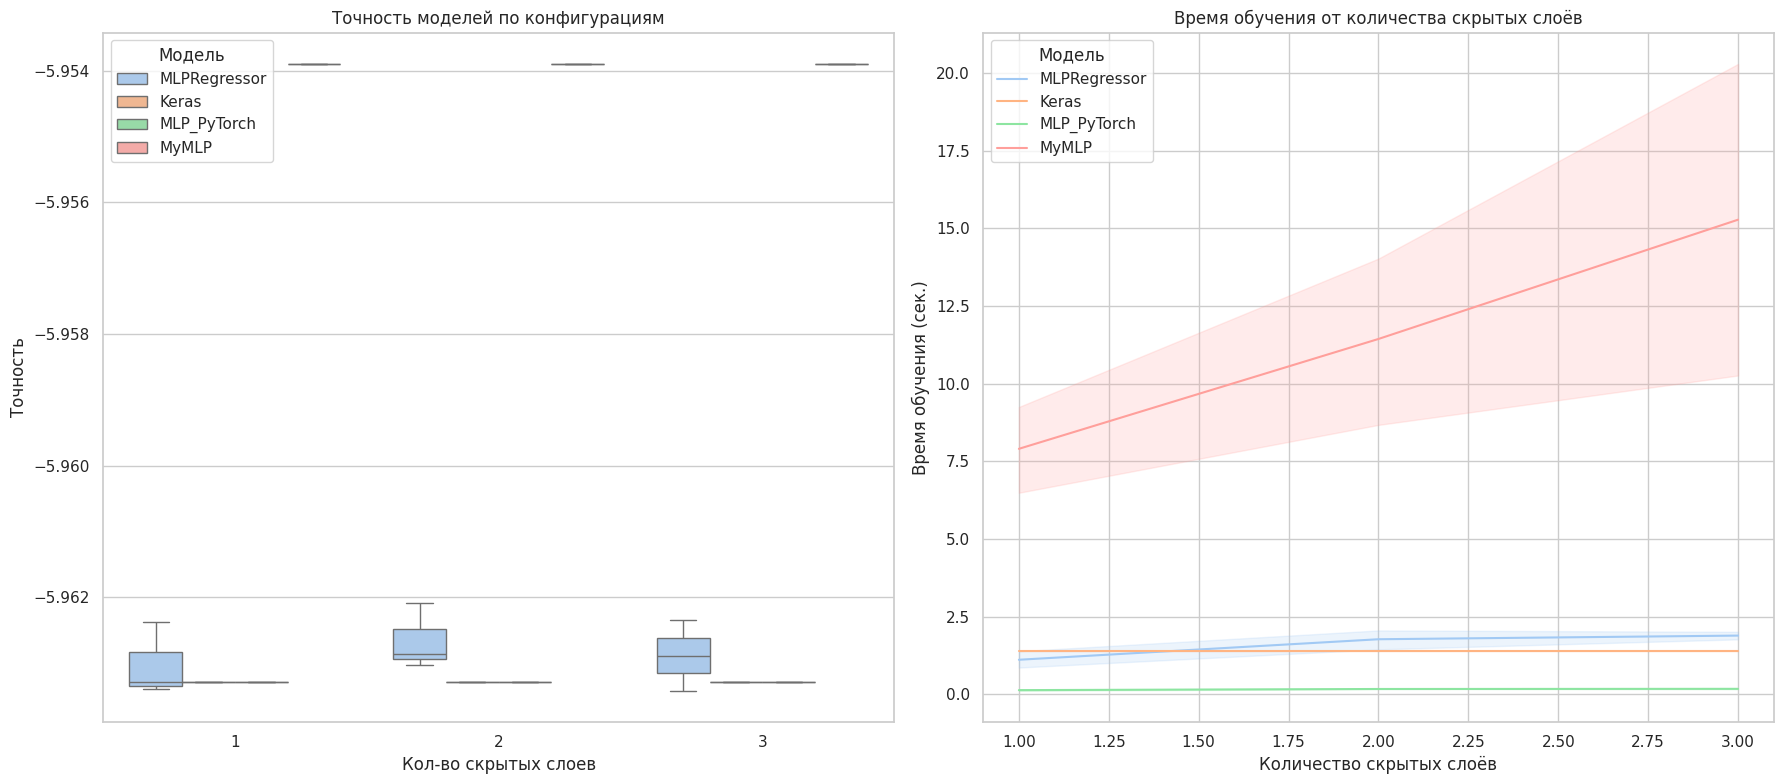

In [40]:
itog['hidden_layer_sizes_str'] = itog['hidden_layer_sizes'].astype(str)

# Устанавливаем стиль и палитру
sns.set(style="whitegrid", palette="pastel")

# Создание подграфиков
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# График 1: Точность моделей по конфигурациям
sns.boxplot(
    x='num_hidden_layer_sizes',
    y='score',
    hue='model',
    data=itog,
    ax=axes[0]
)
axes[0].set_title('Точность моделей по конфигурациям')
axes[0].set_xlabel('Кол-во скрытых слоев')
axes[0].set_ylabel('Точность')
axes[0].legend(title='Модель')

# График 2: Время обучения в зависимости от числа слоёв
sns.lineplot(
    x='num_hidden_layer_sizes',
    y='training_time',
    hue='model',
    data=itog,
    ax=axes[1],
    dashes=False
)
axes[1].set_title('Время обучения от количества скрытых слоёв')
axes[1].set_ylabel('Время обучения (сек.)')
axes[1].set_xlabel('Количество скрытых слоёв')
axes[1].legend(title='Модель')

plt.tight_layout()
plt.show()